# これがメインのファイルです

In [6]:
import pandas as pd
import numpy as np
import re
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import product
from scipy import stats

%matplotlib inline
plt.style.use('ggplot')
#plt.style.use('seaborn-pastel')
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm_notebook as tq

import matplotlib as mpl
font = {"family":"osaka"}
mpl.rc('font', **font)

sys.path.append("..")
from utils.util_functions import *

pd.set_option('display.max_rows', 500)

In [7]:
#event_df = make_df(data_dir=DETAIL_DATA_DIR_MLB)
#event_df = pd.read_csv(os.path.join(ROOT_DIR, "event_df.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2017 = make_df(end=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2017 = pd.read_csv(os.path.join(ROOT_DIR, "df_2017.csv"), index_col=0, encoding="cp932", dtype=object)
#df_2018 = make_df(start=1944417, data_dir=DETAIL_DATA_DIR_MLB)
#df_2018 = pd.read_csv(os.path.join(ROOT_DIR, "df_2018.csv"), index_col=0, encoding="cp932", dtype=object)
files = os.listdir(DETAIL_DATA_DIR_MLB)[1:]
names = pd.Series(files).apply(lambda x: int(x.split(".")[0]))
files_2017 = names[names<=1944417].apply(lambda x: str(x)+".csv")
files_2018 = names[names>1944417].apply(lambda x: str(x)+".csv")
column = "得点"
teams_mlb = list(set(pd.read_csv(os.path.join(SCORE_DATA_DIR_MLB, "score_mlb.csv"), encoding="cp932", index_col=0).表チーム))
teams_mlb.remove("ア・リーグ")
first_teams = ['Rソックス', 'インディアンス', 'アストロズ', 'ブレーブス', 'ブリュワーズ', 'ドジャース']
second_teams = ['ヤンキース', 'ツインズ', 'アスレチックス', 'ナショナルズ', 'カブス', 'ロッキーズ']
third_teams = ['レイズ', 'タイガース', 'マリナーズ', 'フィリーズ', 'カージナルス', 'Dバックス']
fourth_teams = ['ブルージェイズ', 'Wソックス',  'エンゼルス', 'メッツ', 'パイレーツ', 'ジャイアンツ']
fifth_teams = ['オリオールズ', 'ロイヤルズ', 'レンジャーズ', 'マーリンズ', 'レッズ', 'パドレス']

In [8]:
def pos_neg(team, nlead=5, nbehind=4, year="both"):
    if year == "both":
        df = event_df[event_df.攻撃チーム==team]
    elif year == 2018:
        df = df_2018[df_2018.攻撃チーム==team]
    elif year == 2017:
        df = df_2017[df_2017.攻撃チーム==team]
        
    # 点差関係なし
    triple = make_inning_triple(make_inning_list(df, score_end=1, how="own"))
    lst = make_flattened_list(triple[:])
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    all_imp, all_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    #  nlead点差以上リード
    lst = triple_on_score_diff(team, nlead, 30, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    pos_imp, pos_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    # nbehind点差以上ビハインド
    lst = triple_on_score_diff(team, -nbehind, -1, year)
    improved_score_list = []
    deteriorated_score_list = []
    for three_series in [elem for elem in lst if elem[0][0]!="3000" and elem[1][0]!="3000"]:
        if is_improved(three_series[0][0], three_series[1][0]):
            improved_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
        elif is_deteriorated(three_series[0][0], three_series[1][0]):
            deteriorated_score_list.append(weighted_score(three_series[1][0], three_series[2][1]-three_series[1][1]))
    neg_imp, neg_det = np.mean(improved_score_list), np.mean(deteriorated_score_list)
    
    return [team, all_imp, all_det, pos_imp, pos_det, neg_imp, neg_det]

In [11]:
def mean_positive_inhibition(n):
    res = []
    for team in teams_mlb:
        curr = pos_neg(team, n, n-1, year=2018)
        curr[0] = curr[0] + "2018"
        res.append(curr)
        curr = pos_neg(team, n, n-1, year=2017)
        curr[0] = curr[0] + "2017"
        res.append(curr)
    df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)
    df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
    return np.mean(df["positive_inhibition"])

In [13]:
res = []
for i in range(3, 10):
    mpi = mean_positive_inhibition(i)
    res.append(mpi)
    print(i, mpi)

3 -0.06419632495013909
4 -0.0698282661928728
5 -0.05846154341432774
6 -0.04652281015878008
7 -0.04604074623407268
8 0.1217216097987104
9 0.11057127090395219


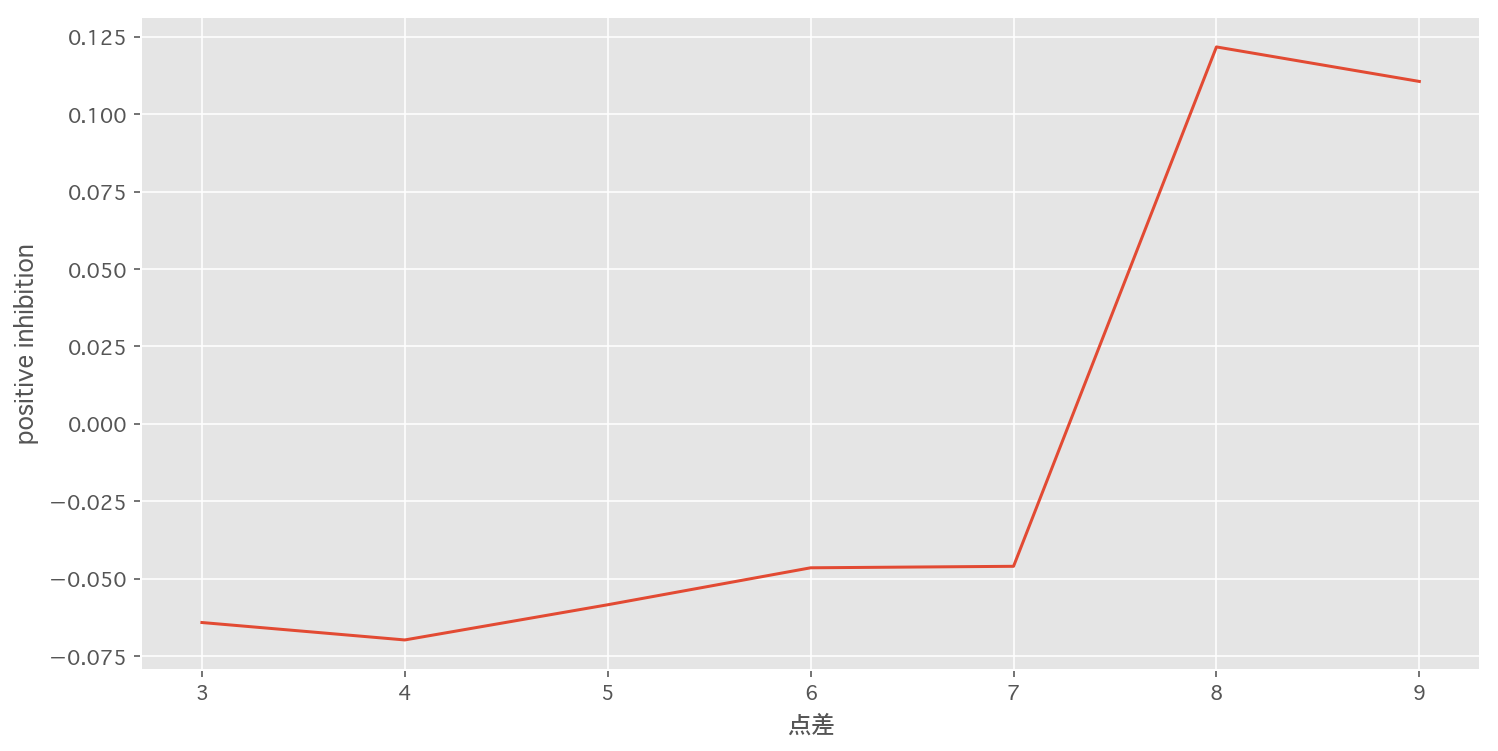

In [15]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(3, 10)], res)
plt.title("")
plt.xlabel("点差")
plt.ylabel("positive inhibition")
plt.show()

In [5]:
res = []
for team in teams_mlb:
    curr = pos_neg(team, year=2018)
    curr[0] = curr[0] + "2018"
    res.append(curr)
    print(curr[0])
    curr = pos_neg(team, year=2017)
    curr[0] = curr[0] + "2017"
    res.append(curr)
    print(curr[0])

マリナーズ2018
マリナーズ2017
Rソックス2018
Rソックス2017
エンゼルス2018
エンゼルス2017
ドジャース2018
ドジャース2017
パドレス2018
パドレス2017
カブス2018
カブス2017
ブレーブス2018
ブレーブス2017
アスレチックス2018
アスレチックス2017
フィリーズ2018
フィリーズ2017
オリオールズ2018
オリオールズ2017
Wソックス2018
Wソックス2017
カージナルス2018
カージナルス2017
インディアンス2018
インディアンス2017
レイズ2018
レイズ2017
マーリンズ2018
マーリンズ2017
パイレーツ2018
パイレーツ2017
ナショナルズ2018
ナショナルズ2017
レンジャーズ2018
レンジャーズ2017
ロッキーズ2018
ロッキーズ2017
メッツ2018
メッツ2017
ブルージェイズ2018
ブルージェイズ2017
ツインズ2018
ツインズ2017
ブリュワーズ2018
ブリュワーズ2017
レッズ2018
レッズ2017
ジャイアンツ2018
ジャイアンツ2017
タイガース2018
タイガース2017
ヤンキース2018
ヤンキース2017
アストロズ2018
アストロズ2017
Dバックス2018
Dバックス2017
ロイヤルズ2018
ロイヤルズ2017


In [6]:
df = pd.DataFrame(res, columns=["チーム", "all_imp", "all_det", "pos_imp", "pos_det", "neg_imp", "neg_det"]).set_index("チーム", drop=True)

In [7]:
df["positive_inhibition"] = - df["pos_imp"] + df["all_imp"]
df["negative_facilitation"] = df["neg_det"] - df["all_det"]

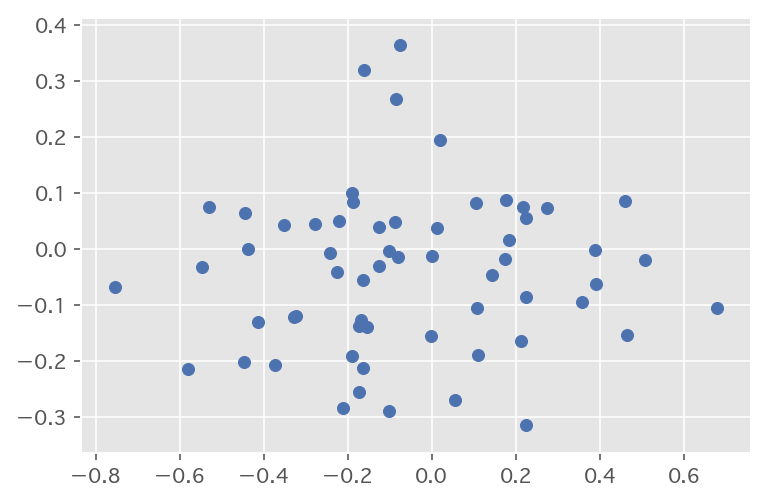

In [8]:
df[["positive_inhibition", "negative_facilitation"]]
plt.scatter(df["positive_inhibition"], df["negative_facilitation"])

In [9]:
df

,all_imp,all_det,pos_imp,pos_det,neg_imp,neg_det,positive_inhibition,negative_facilitation
チーム,,,,,,,,
マリナーズ2018,0.905469,0.844746,0.721078,1.071789,0.976364,0.860808,0.184391,0.016062
マリナーズ2017,0.972623,0.952931,1.073401,1.717161,1.034130,0.664024,-0.100778,-0.288907
Rソックス2018,0.911387,0.937122,0.985993,0.758462,0.977283,1.300632,-0.074606,0.363510
Rソックス2017,0.835661,0.690565,0.823048,0.267297,0.828791,0.727758,0.012613,0.037193
エンゼルス2018,0.901478,1.084302,1.274511,0.957858,0.820922,0.877381,-0.373033,-0.206921
エンゼルス2017,0.915604,0.801462,1.041092,0.609636,0.929382,0.771223,-0.125488,-0.030239
ドジャース2018,0.953928,1.013884,1.179696,0.681225,0.805698,0.971918,-0.225768,-0.041967
ドジャース2017,0.905195,1.002881,1.095143,0.972405,0.962859,1.103426,-0.189948,0.100545
パドレス2018,0.806579,0.916008,1.337238,0.115599,0.731803,0.990573,-0.530660,0.074565


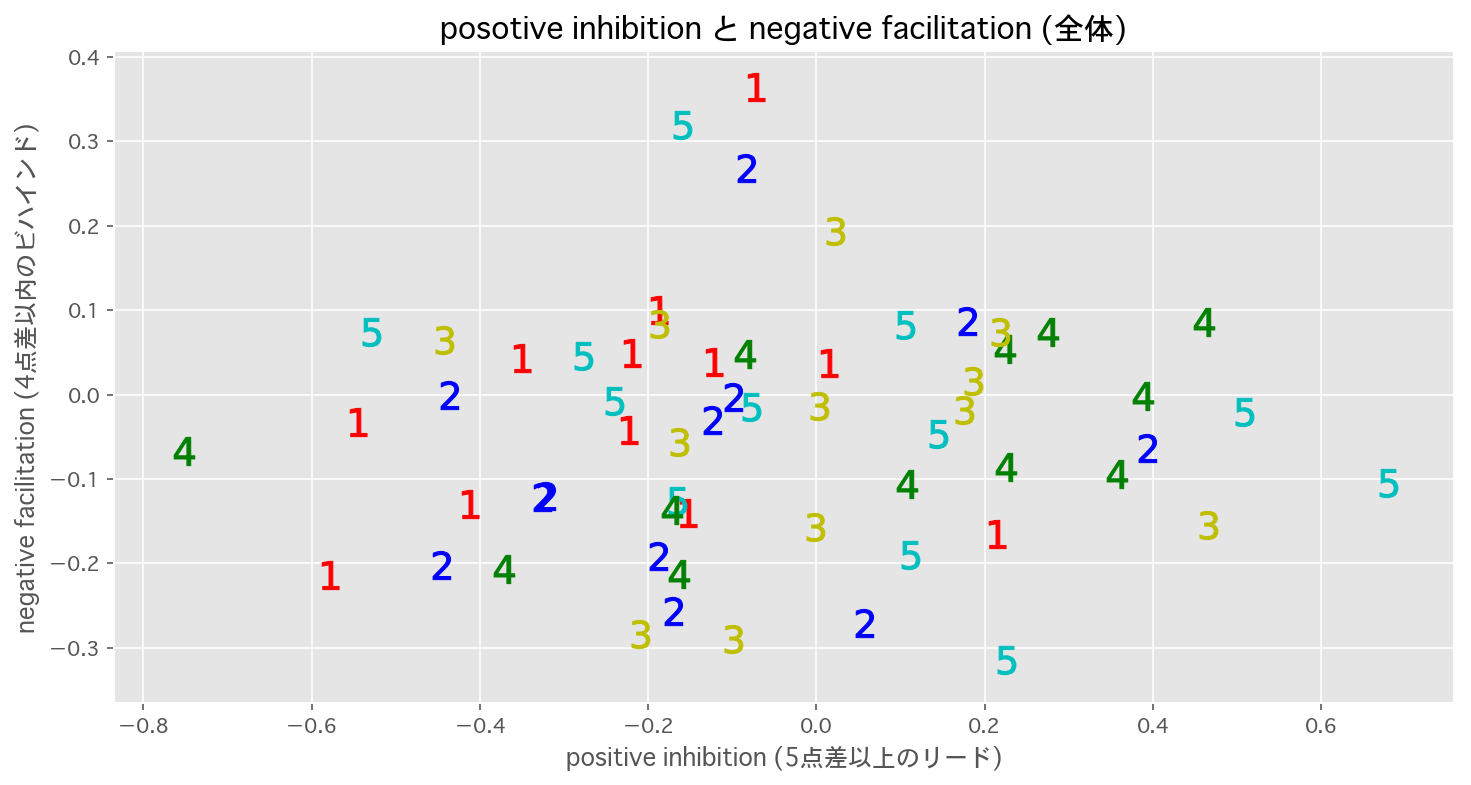

In [18]:
plt.figure(figsize=(12, 6))
colors = ["r", "b", "y", "g", "c"]
for team in df.index:
    pos_inh = df.loc[team, "positive_inhibition"]
    neg_fac = df.loc[team, "negative_facilitation"]
    plt.scatter([pos_inh], [neg_fac], marker="${}$".format(ranking(team[:-4], int(team[-4:]))), color=colors[ranking(team[:-4], int(team[-4:]))-1], s=200)
plt.title("posotive inhibition と negative facilitation (全体)", fontsize=15)
plt.xlabel("positive inhibition (5点差以上のリード)")
plt.ylabel("negative facilitation (4点差以内のビハインド)")

In [11]:
order_pos_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_pos_dict[ranking(team, year)] += df.loc[teamyear, "positive_inhibition"]

In [12]:
order_pos_dict

defaultdict(int,
            {1: -2.6617735938497051,
             2: -1.5843455109183191,
             3: -0.051681542585792772,
             4: 0.48241422217406255,
             5: 0.30769382032009041})

In [13]:
order_neg_dict = defaultdict(int)
for teamyear in df.index:
    team = teamyear[:-4]
    year = int(teamyear[-4:])
    order_neg_dict[ranking(team, year)] += df.loc[teamyear, "negative_facilitation"]

In [14]:
order_neg_dict

defaultdict(int,
            {1: -0.090015649764818573,
             2: -0.90354999196291763,
             3: -0.53885691975705485,
             4: -0.64965265126721372,
             5: -0.30270420318058766})

In [39]:
res_df = pd.DataFrame(np.array([list(order_pos_dict.values()), list(order_neg_dict.values())]), columns=[1, 2, 3, 4, 5], index=["positive_inhibition", "negative_facilitation"]).T

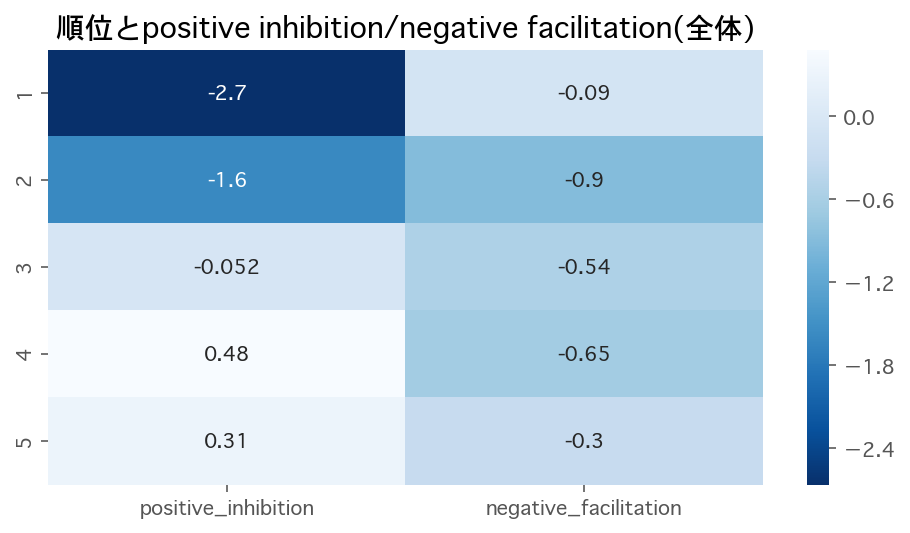

In [49]:
import seaborn as sns
plt.figure(figsize=(8, 4))
sns.heatmap(res_df, cmap='Blues_r', annot=True)
plt.title("順位とpositive inhibition/negative facilitation(全体)")

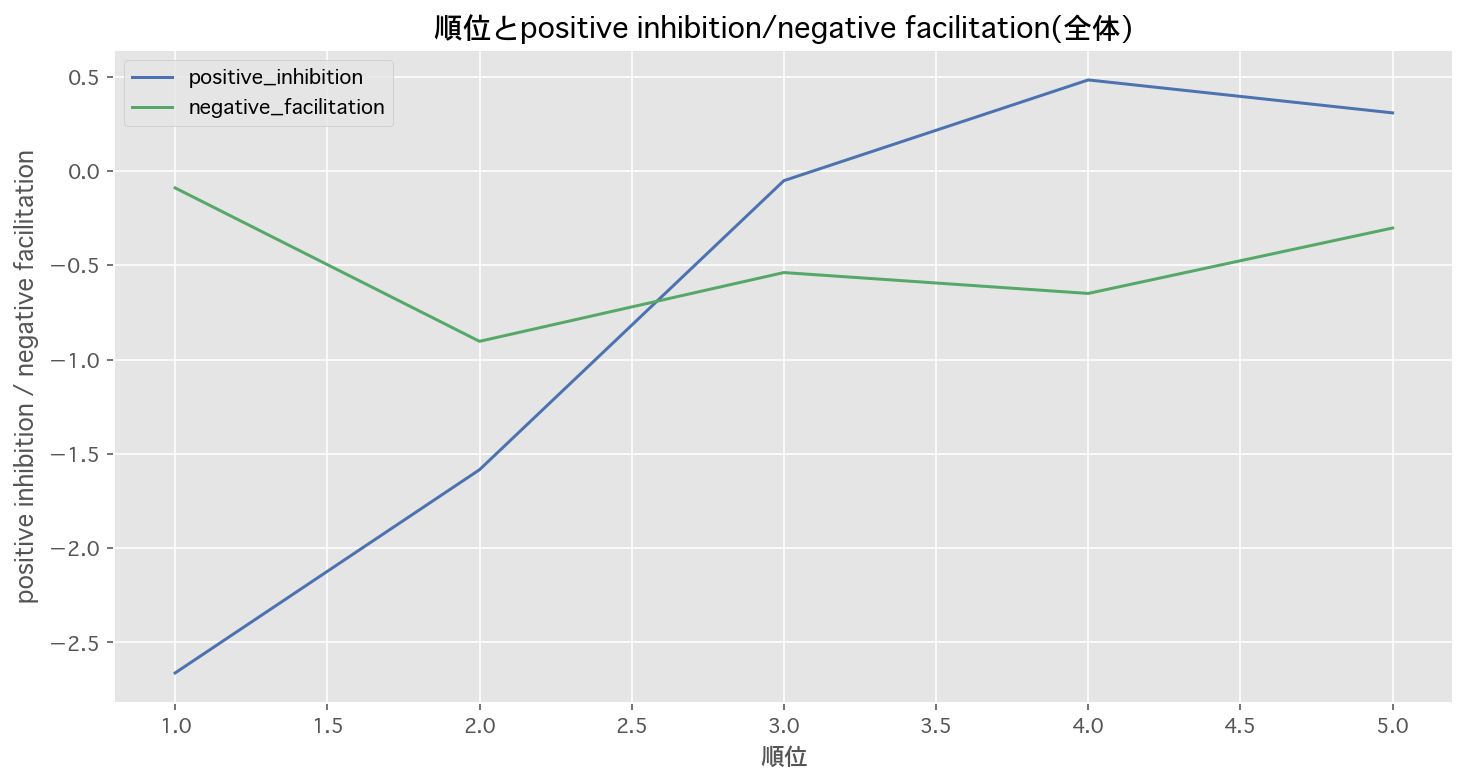

In [50]:
pd.DataFrame([list(order_pos_dict.values()), list(order_neg_dict.values())], index=["positive_inhibition", "negative_facilitation"], columns=[1, 2, 3, 4, 5]).T.plot(figsize=(12, 6))
plt.title("順位とpositive inhibition/negative facilitation(全体)")
plt.xlabel("順位")
plt.ylabel("positive inhibition / negative facilitation")

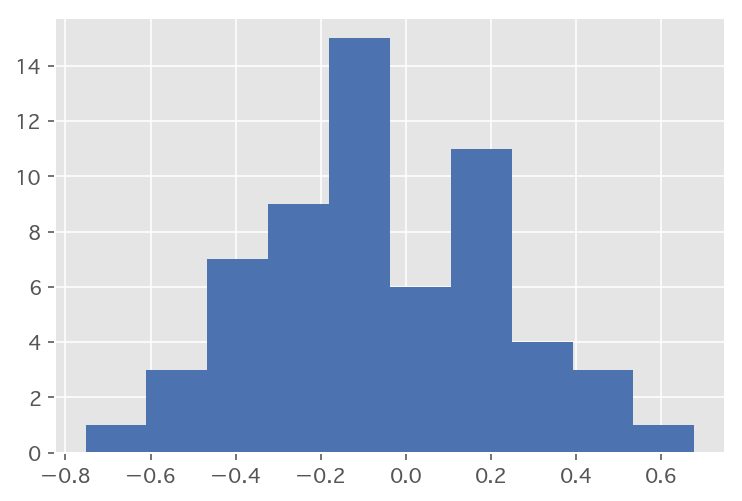

In [16]:
df.loc[:, "positive_inhibition"].hist()

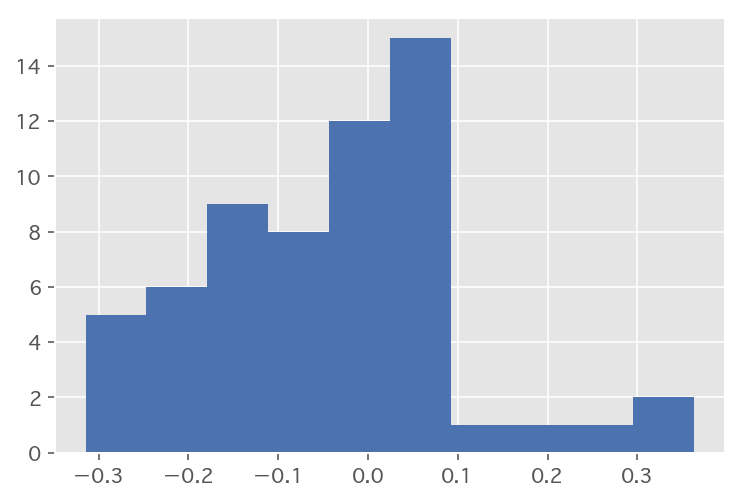

In [17]:
df.loc[:, "negative_facilitation"].hist()

In [2]:
winning_rate_df = pd.read_csv(os.path.join(DATA_DIR, "winning_rate.csv"), index_col=0)

In [7]:
type(winning_rate_df["2018"]["Rソックス"])

numpy.float64